This notebook will compute and plot the xHI and tau vs z as in Munoz+24 [2404.07250, Fig 1). It's fully customizable for what UVLF, xiion, and fesc you plug in. Built in options are:

UVLF: Donnan+24*, Bouwens+21*, Finkelstein&Bagley22, Chemrynska+24

xiion: Simmonds24a,24b; Endsley+24, Robertson+15, Munoz+26*

beta-fesc: Chisholm+22*, or constant (for the former beta-MUV can be : Bouwens+14, Zhao&Furlanetto24, Jecmen+26*)



The * indicates the default option (for UVLFs there's one for low z<9 and one for high z>9)

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import copy

import zeus21 #for EoR calculations - otherwise you can rewrite them

# Galaxy propeties (UVLF, xiion, fesc)

In [ ]:
#we need to set CosmoParams to run some calculations below
CosmoParams_input = zeus21.Cosmo_Parameters_Input(zmin_CLASS = 4.0)
UserParams = zeus21.User_Parameters(precisionboost=1.5)
ClassyCosmo = zeus21.runclass(CosmoParams_input)
CosmoParams = zeus21.Cosmo_Parameters(UserParams,CosmoParams_input, ClassyCosmo) 

### Define UVLFs

Important note: the UVLFs below are all *observed* (i.e., they have dust attenuation). In principle you should use the *intrinsic* UVLFs, modeling dust attenuation and removing it, but that introduces uncertainties. Alternatively, one can take fesc to be after dust, but of course that is difficult due to sight line variations etc. We'll use observed UVLFs and fesc, but keep in mind it underestimates Nion.

In [3]:
def UVLF_int_Bouwens(z,MUV):
    'from bouwens 2021, fit vs z'
    zt = 2.46
    MUVstar = (-21.03 + -0.04 *(z-6.0)) * np.heaviside(z-zt,0.5)
    phistar = 0.4*1e-3 * 10**(-0.33 *(z-6.0) -0.024*(z-6.0)**2) #/Mpc3
    alphastar = -1.94 - 0.11 *(z-6.0)

    Lum = 10**(-0.4*(MUV - MUVstar) )

    return phistar *(np.log(10)/2.5) * Lum**(alphastar+1) * np.exp(-Lum) #/Mpc3/mag

def UVLF_int_Donnan(z,MUV):
    'from donnan+24, DPL fit for z>=7, 2403.03171'

    Mstar = -20.95 + 0.11 * z
    logphistar = -0.14 * z - 2.36
    alpha = -2.04e-4 * z - 2.1
    beta = 0.138*z - 5.13

    Lum = 10**(0.4*(MUV - Mstar) )

    phi = 10**logphistar / (Lum**(alpha+1) + Lum**(beta+1)) 
    return phi


def UVLF_int_Finkelstein(z,MUV):
    'from https://arxiv.org/pdf/2207.02233.pdf, Eq 1. Note that it has a turnover built in'

    Pg0, Pg1 = -1.45, -0.31
    Mg0, Mg1 = -21.18, 0.02
    Ag0, Ag1 = -1.27, -0.11
    Bg0, Bg1 = -4.79, 0.05
    Tg0, Tg1, Tg2 = -21.32, 2.26, -0.16
    Dg0, Dg1 = -0.76, 0.19
    
    
    logphistar = Pg0 + Pg1*(1+z)
    Mgstar = Mg0 + Mg1 *(1+z)
    alphagstar = Ag0 + Ag1 *(1+z)
    betagstar = Bg0 + Bg1 *(1+z)
    Mtg = Tg0 + Tg1 *(1+z)+ Tg2 *(1+z)**2
    deltagstar = Dg0 + Dg1 *(1+z)


    Lum = 10**(0.4*(MUV - Mgstar) )

    phi = 10**logphistar / (Lum**(alphagstar+1) + Lum**(betagstar+1)) 
    phi/=(1 + 10**(0.4*(MUV - Mtg) * deltagstar ))
    
    return phi #/Mpc3/mag


def UVLF_int_Chemerynska(z,MUV):
    TODO

#for going from high to low z
def stepfunc(z,zc,dz):
    '1 for z>zc, 0 below, width dz. generalizes heaviside'
    return (np.tanh((z-zc)/dz)+1)/2.

Text(0, 0.5, '$\\Phi_{\\rm UV}$ [Mpc-3]')

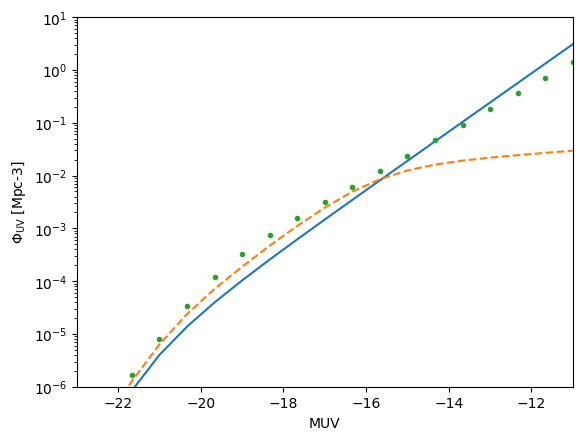

In [4]:
_z=10.; _MUVs=np.linspace(-23,-9,22)
plt.plot(_MUVs,UVLF_int_Bouwens(_z,_MUVs))

plt.plot(_MUVs,UVLF_int_Finkelstein(_z,_MUVs),'--')

plt.plot(_MUVs,UVLF_int_Donnan(_z,_MUVs),'.')

        
plt.yscale('log')
plt.xlim(-23,-11)
plt.ylim(1e-6,1e1)
plt.xlabel(r'MUV')
plt.ylabel(r'$\Phi_{\rm UV}$ [Mpc-3]')


In [5]:
##we implement a cutoff at some MUV too, as a free parameter to vary:
from scipy.special import erf
def UVLFcutoff(MUVlist, Mturn, DeltaMturn=1.0):
    return 0.5 * (1. - erf((MUVlist - Mturn)/DeltaMturn) )

### Define beta-MUV relations here

In [6]:
def beta_Zhao(z, MUV):
    'from https://arxiv.org/pdf/2401.07893.pdf, table 1'
    betaM0z0 = -1.58
    dbetaM0dz = -0.081

    dbetaM0dMUVz0 = -0.216
    ddbetaM0dMUVdz = 0.012

    MUV0 = -19.5
    betaM0 = betaM0z0 + z * dbetaM0dz
    dbetaM0 = (MUV - MUV0).T * (dbetaM0dMUVz0 + ddbetaM0dMUVdz * z)
    
    sol2 = dbetaM0 + betaM0 #beta_M0 + db/dMUV|M0 (DeltaMUV)at M0=-19.5
    
    #cap at -3 just in case
    return np.fmax(-3.0, sol2)

def beta_Bouw14(z, MUV):
    'MUV input assumed to be NMUV x Nz. Just linear fit from Bouwens+14. MUV should be observed (ie with dust att.)'
    MUV0 = -19.5
    betaM0 = np.interp(z, zdatbeta, betaMUVatM0, left=betaMUVatM0[0], right=betaMUVatM0[-1])
    dbetaM0 = (MUV - MUV0).T * np.interp(z, zdatbeta, dbeta_dMUV, left=dbeta_dMUV[0], right=dbeta_dMUV[-1]) 
    
    sol2 = dbetaM0 + betaM0 #beta_M0 + db/dMUV|M0 (DeltaMUV)at M0=-19.5
    
    #cap at -3 just in case
    return np.fmax(-3.0, sol2)

zdatbeta = [2.5,3.8,5.0,5.9,7.0,8.0]
betaMUVatM0 = [-1.7,-1.85,-1.91,-2.00,-2.05,-2.13]
dbeta_dMUV = [-0.20,-0.11,-0.14,-0.20,-0.20,-0.15]
#silly interpolator for these below

def beta_Jecmen(z,MUV):
    'from Jecmen+26, GLIMPSE'
    #TO DO 
    return -np.inf

Text(0, 0.5, '$\\beta$')

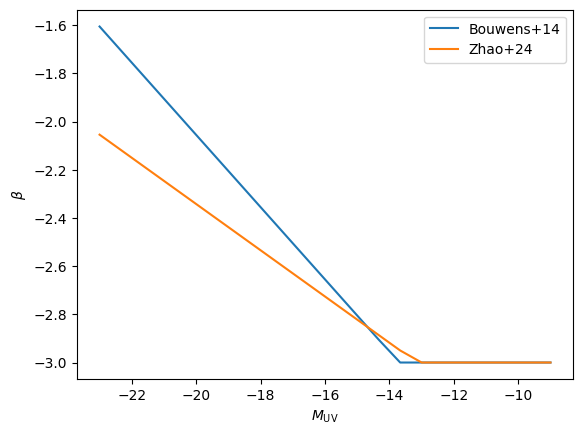

In [7]:
plt.plot(_MUVs,beta_Bouw14(_z,_MUVs), label='Bouwens+14')
plt.plot(_MUVs,beta_Zhao(_z,_MUVs), label='Zhao+24')

plt.legend()
plt.xlabel(r'$M_{\rm UV}$')
plt.ylabel(r'$\beta$')

In [8]:
def fesc_Chisholm(betaUV,sigmabetaUV = 0.34):
    """
    Returns the MEAN fesc, assuming that at fixed MUV beta is a gaussian distr of betaUV with width sigmabetaUV(=0.34), as in Smit+12.
    Basically, the mean <fesc> is larger than 10**<logfesc> by ~10%, so we correct for that. we cap at unity below.
    """
    slope = -1.22
    amp = 1.3e-4
    return amp * 10**(slope*betaUV) * np.exp((slope*np.log(10))**2*sigmabetaUV**2/2.0) 

### Define xiions vs MUV

In [9]:
def xion_Simmonds24a(MUV, z):
    'from JADES high z gals, 2310.01112; we cut at MUV=-16.5 and z=9 where their sample ends. Line-emitter selected, so does not need be representative'
    MUV = np.fmin(-16.5, MUV)
    z = np.fmin(9., z)
    return 10**(27.33 + 0.11 * MUV + 0.05 * z)

def xion_Simmonds24b(MUV, z):
    'Mass-complete sample from Simmonds+24b 2409.01286'
    amp = XX
    MUVslope = XX
    zslope =XX
    return 10**(amp + MUVslope * (MUV+17.) + zslope * (z-6.))

def xion_Endsley24(MUV, z):
    'from 2306.05295, consistent with 25.5 constant, so for simplicity we return that'
    return 10**(25.5) * np.ones_like(MUV)

def xion_Robertson15 (MUV, z):
    'value in Robertson 2015. its 1e53.14 / SFR unit and uses κUV = 2.5 ×10−10 M⊙ yr L'
    kappaUV = 1.15e-28 #SFR/LUV, from Madau and Dickinson
    return 10**(53.14)*kappaUV

def xion_Munoz26(MUV, z):
    'from Munoz+26 (to appear), Eq. (22), fitted at z=4-6.'
    amp = 25.38
    MUVslope = -0.008
    zslope = 0.024
    return 10**(amp + MUVslope * (MUV+17.) + zslope * (z-6.))

Text(0, 0.5, '$\\xi_{\\rm ion}$ [Hz/erg]')

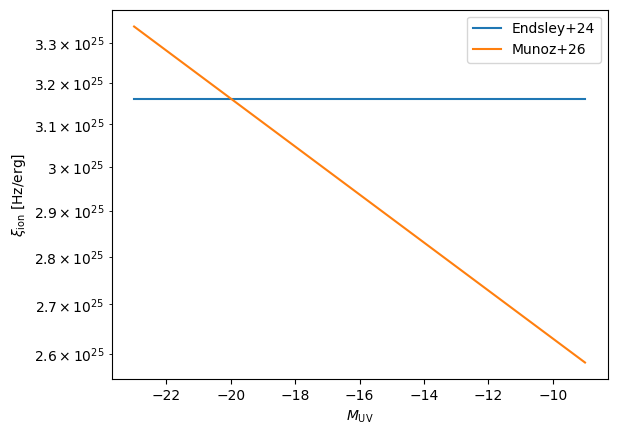

In [10]:
# plt.plot(_MUVs,xion_Simmonds24b(_MUVs,_z), label='Simmonds+24b')
plt.semilogy(_MUVs,xion_Endsley24(_MUVs,_z), label='Endsley+24')
plt.semilogy(_MUVs,xion_Munoz26(_MUVs,_z), label=rf'Munoz+26')

plt.legend()
plt.xlabel(r'$M_{\rm UV}$')
plt.ylabel(r'$\xi_{\rm ion}$ [Hz/erg]')

# Define the calculations

In [11]:
def tau_reio(Cosmo_Parameters, zlist, xHI):
    "Returns the optical depth to reionization given a neutral frac xHI as a func of zlist"
    #assume HeII at z=4, can be varied with zHeIIreio

    #first integrate for z<zmin, assumed xHI=0
    _lowestz = np.min(zlist)
    _zlistlowz = np.linspace(0,_lowestz,100)
    _nelistlowz = zeus21.cosmology.n_H(Cosmo_Parameters,_zlistlowz)*(1 + Cosmo_Parameters.x_He + Cosmo_Parameters.x_He * np.heaviside(zeus21.constants.zHeIIreio - _zlistlowz,0.5))
    _distlistlowz = 1.0/zeus21.cosmology.HubinvMpc(Cosmo_Parameters,_zlistlowz)/(1+_zlistlowz)
    _lowzint = zeus21.constants.sigmaT * np.trapezoid(_nelistlowz*_distlistlowz,_zlistlowz) * zeus21.constants.Mpctocm


    #now the rest of integral
    xHIint = np.fmin(np.fmax(xHI,0.0),1.0) #at min 0%, at max 100%
    _zlisthiz = zlist
    _nelistlhiz = zeus21.cosmology.n_H(Cosmo_Parameters,_zlisthiz) * (1 + Cosmo_Parameters.x_He) * (1.0 - xHIint)
    _distlisthiz = 1.0/zeus21.cosmology.HubinvMpc(Cosmo_Parameters,_zlisthiz)/(1+_zlisthiz)

    _hizint = zeus21.constants.sigmaT * np.trapezoid(_nelistlhiz*_distlisthiz,_zlisthiz) * zeus21.constants.Mpctocm

    return(_lowzint + _hizint)


In [12]:
def Niondot_generic(z, Mturn, xiion_model, beta_model, fesc_model, UVLF_fit,
                    fesc_value = None, sigmabeta =0.34):
    'Returns Nion in 1/yr, with different fesc, UVLF, and xiion models'

    Muvintegral = np.linspace(-30,-5,124)
    MUVwidths = np.diff(Muvintegral)
    MUVwidths = np.append(MUVwidths,MUVwidths[-1])
    
    if (UVLF_fit == 'Bouwens'):
        UVLFhere = UVLF_int_Bouwens(z,Muvintegral)
    elif (UVLF_fit == 'Donnan'): #for z>9 donnan, otherwise Bouwens
        _zcutDonnan, _dzcutDonnan = 9., 0.5 #to not be too sharp
        UVLFhere = UVLF_int_Donnan(z,Muvintegral) * stepfunc(z,_zcutDonnan,_dzcutDonnan) + UVLF_int_Bouwens(z,Muvintegral) * (1. - stepfunc(z,_zcutDonnan,_dzcutDonnan))
    elif (UVLF_fit == 'Finkelstein'):
        UVLFhere = UVLF_int_Finkelstein(z,Muvintegral)
    elif (UVLF_fit == 'Chemerynska'):
        UVLFhere = UVLF_int_Chemerynska(z,Muvintegral)
    else:
        print('ERROR in Niondot_generic, which UVLF_fit??')
        return 0.

    if (xiion_model == 'Simmonds24a'):
        xi_ionfun = xion_Simmonds24a
    elif (xiion_model == 'Endsley24'):
        xi_ionfun = xion_Endsley24
    elif (xiion_model == 'Robertson15'):
        xi_ionfun = xion_Robertson15
    elif (xiion_model == 'Munoz26'):
        xi_ionfun = xion_Munoz26
    else:
        print('ERROR in Niondot_generic, which xiion_model??')
        return -np.inf
    xi_ion = xi_ionfun(Muvintegral,z) #in 1/(erg/s/Hz)*1/s

    if fesc_model == 'constant_fesc':
        fesclist = fesc_value
    elif fesc_model == 'Chisholm_fesc':
        if (beta_model == 'Zhao24'):
            betafun = beta_Zhao
        elif (beta_model == 'Bouwens14'):
            betafun = beta_Bouw14
        elif (beta_model == 'Jecmen26'):
            betafun = beta_Jecmen
        else:
            print('ERROR in Niondot_generic! Select a beta_model for Chisholm fesc_model')
            return -np.inf
        betabarlist = betafun(z,Muvintegral) #avg betaUV relation from Bouwens, it's on observations!
        fesclist= fesc_Chisholm(betabarlist) #lowz analogues 
    else:
        print('ERROR in Niondot_generic! Select a fesc_model')
        return -np.inf
        
    fesclist = np.fmin(fesclist, 1.0) #cap at 1 just in case 

    xi_ion_timesfesc = xi_ion * fesclist   
    LUVlist = 10**((51.63 - Muvintegral)/2.5)
    Nionperhalo = xi_ion_timesfesc *LUVlist*zeus21.constants.yrTos #in 1/yr
    CutoffLowM = UVLFcutoff(Muvintegral,Mturn)
    Niondotz = np.trapezoid(CutoffLowM*UVLFhere*Nionperhalo,Muvintegral)/zeus21.cosmology.n_H(CosmoParams,0.)/(zeus21.constants.Mpctocm**3.0)
    return Niondotz




def EoR_hist(Clumpingfactor, MUVturn, xiion_model, beta_model,fesc_model, UVLF_fit, fesc_value = None, T4=2.0):
    """
    Returns z, xHI, tau, and Nion for whatever input of:
    clump : clumping factor 
    MUVturn : UV magnitude turnover
    xi_ionfun: xiion vs MUV,z function
    betafun: betaUV vs MUV function
    fesc_model: whichever fesc model (Chisholm+22 or constant)
    FROMUVLF: which UVLF is chosen
    T4 = T/10^4K for recombination coeff. 
    """

    zintegral = np.linspace(4,20,333)
    dzintegral = np.mean(zintegral[1:]-zintegral[:-1])

    Niontab =np.array([Niondot_generic(zz, MUVturn, xiion_model, beta_model, fesc_model, UVLF_fit, fesc_value=fesc_value) for zz in zintegral])

    _clumping = Clumpingfactor #assumed constant, can be funct of z  
    alphaBeff = zeus21.constants.alphaB * T4**-0.845
    _trec0 = 1.0/(alphaBeff * zeus21.cosmology.n_H(CosmoParams,0) *(1 + CosmoParams.x_He) * _clumping)#t_recombination  at z=0, in sec
    coeffQzp = dzintegral/zeus21.cosmology.Hubinvyr(CosmoParams,zintegral)/(1+zintegral) #Deltaz * dt/dz. Units of 1/yr, inverse of niondot
    #solve Q=xHII by iterating

    _Q0iteration = 0.5 #0th iteration will be wrong
    trec = _trec0/(1+zintegral)**3/zeus21.constants.yrTos #in yr at each time t
    _Q1iteration = 0.0
    while(np.sum(np.abs(_Q1iteration-_Q0iteration))>0.001):
        _Q1iteration = _Q0iteration
        _Q0iteration = np.cumsum(coeffQzp[::-1] * (Niontab - _Q1iteration/trec)[::-1])[::-1]
    Qion_avg = _Q0iteration

    xHI = np.fmax(1 - Qion_avg,0.)
    tau = tau_reio(CosmoParams,zintegral,xHI)
    return zintegral, xHI, tau, Niontab

In [13]:
##define some xHI(z) measurements, feel free to add and remove at will
zMcGreer = [5.6, 5.9, 6.1];
xHIMcGreermax = [0.09,0.12,0.58];
xHIMcGreermin = [0.,0.,0.];
zSobM = [6.6];
xHISobMmax=[0.5];
xHISobMmin=[0.];
zDavies = [7.09, 7.54];
xHIDaviesmax = [0.48+0.26 , 0.6+0.2]
xHIDaviesmin = [0.48-0.26 , 0.6-0.23]
zGreig = [7.1, 7.5];
xHIGreigmax = [0.4 + 0.21, 0.21+0.17]
xHIGreigmin = [0.4 - 0.19, 0.21-0.19]
zWang = [7];
xHIWangmax = [0.7+0.2]
xHIWangmin = [0.7-0.23]
zMason = [7.,7.9]
xHIMasonmax = [0.55+0.11, 0.76+0.3]
xHIMasonmin = [0.55-0.13 ,0.76]
zNakane =  [7.,8, 11.]
xHINakanemax = [0.79, 0.62+0.15, 0.93 + 0.04]
xHINakanemin = [0.0, 0.62-0.36, 0.93 -0.07]
zHI = np.array( [] +zMcGreer + zSobM + zDavies + zGreig + zWang + zMason + zNakane)
xHImax = np.array([] + xHIMcGreermax + xHISobMmax + xHIDaviesmax + xHIGreigmax + xHIWangmax + xHIMasonmax + xHINakanemax)
xHImin = np.array([]+ xHIMcGreermin + xHISobMmin + xHIDaviesmin + xHIGreigmin + xHIWangmin + xHIMasonmin + xHINakanemin)
xerrz=np.zeros_like(zHI)
xerrz[-1] = 2.0

tauPlanck = 0.054 
errtauPlanck = 0.007

# And make the plot

tauCMB = 0.05223055015390359
tauCMB = 0.08359043307717996


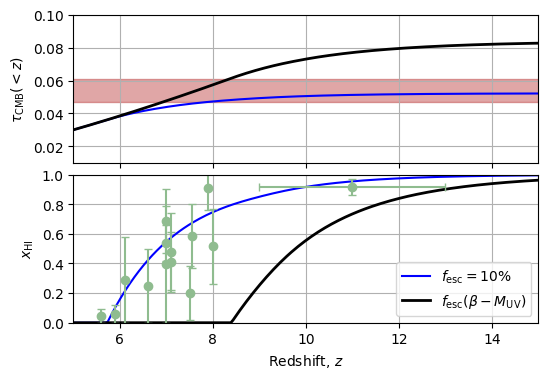

In [14]:
#make your choices:
_MUVcut = -13; 
_CLUMPING=3.;

UVLF_CHOSEN = 'Donnan' #options: 'Finkelstein', 'Bouwens', 'Donnan', 'Chemerynska'
XIION_CHOSEN = 'Munoz26' #options: 'Simmonds24a', 'Simmonds24b', 'Munoz26', 'Endsley24'
BETAMUV_CHOSEN = 'Zhao24' #options: 'Zhao24', 'Bouwens14', 'Jecmen26'



###calculate and plot the xHI and tau vs z for your assumptions
fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True)



#first for fesc = 10%
z1,xHI,tau, Nion_old = EoR_hist(_CLUMPING,_MUVcut,XIION_CHOSEN, None, 'constant_fesc', UVLF_CHOSEN, fesc_value = 0.1)
print('tauCMB =', tau);
axes[1].plot(z1,xHI,'b-', label=r'$f_{\rm esc}=10\%$')
zfortau = copy.deepcopy(z1)
tauvz = np.array([tau_reio(CosmoParams,z1, xHI + np.heaviside(z1-zz,0.5)) for zz in zfortau])
axes[0].plot(zfortau,tauvz,'b-')


#now for the beta-muv and fesc-beta relations
z1,xHI,tau, Nion_old = EoR_hist(_CLUMPING,_MUVcut,XIION_CHOSEN,BETAMUV_CHOSEN, 'Chisholm_fesc', UVLF_CHOSEN)
print('tauCMB =', tau);
axes[1].plot(z1,xHI,'k-',linewidth=2., label=r'$f_{\rm esc}(\beta-M_{\rm UV})$')
zfortau = copy.deepcopy(z1)
tauvz = np.array([tau_reio(CosmoParams,z1, xHI + np.heaviside(z1-zz,0.5)) for zz in zfortau])
axes[0].plot(zfortau,tauvz,'k-',linewidth=2.)

#plot the xHI vs z
axes[1].errorbar(zHI,(xHImax+xHImin)/2,yerr=(xHImax-xHImin)/2,xerr=xerrz,ls='none',fmt='o', capsize=3,color='darkseagreen')


axes[1].legend()
plt.subplots_adjust(hspace=.08)
axes[0].grid()
axes[1].grid()
axes[0].fill_between(z1, np.ones_like(z1) *(tauPlanck-errtauPlanck),np.ones_like(z1) *(tauPlanck+errtauPlanck),alpha=0.4,color='firebrick')
axes[0].set_xlim(5,15)
axes[0].set_ylim(0.01,0.1)
axes[1].set_ylim(0,1.0)
axes[1].set_xlabel(r'Redshift, $z$');
axes[0].set_ylabel(r'$\tau_{\rm CMB}(<z)$');
axes[1].set_ylabel(r'$x_{\rm HI}$');
fig.savefig('EoR_Plot.pdf')

And that's it! Feel free to play with and email me if you have any comments/questions/suggestions!